## PipaFinder Mainframe
## Previsão com Modelo de Regressão Linear

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

In [2]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [4]:
dataframe

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0
...,...
2022-10-21,207.0
2022-10-22,22.0
2022-10-23,50.5


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-10-26 to 2022-10-25
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Quantidade  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<AxesSubplot:xlabel='Data'>

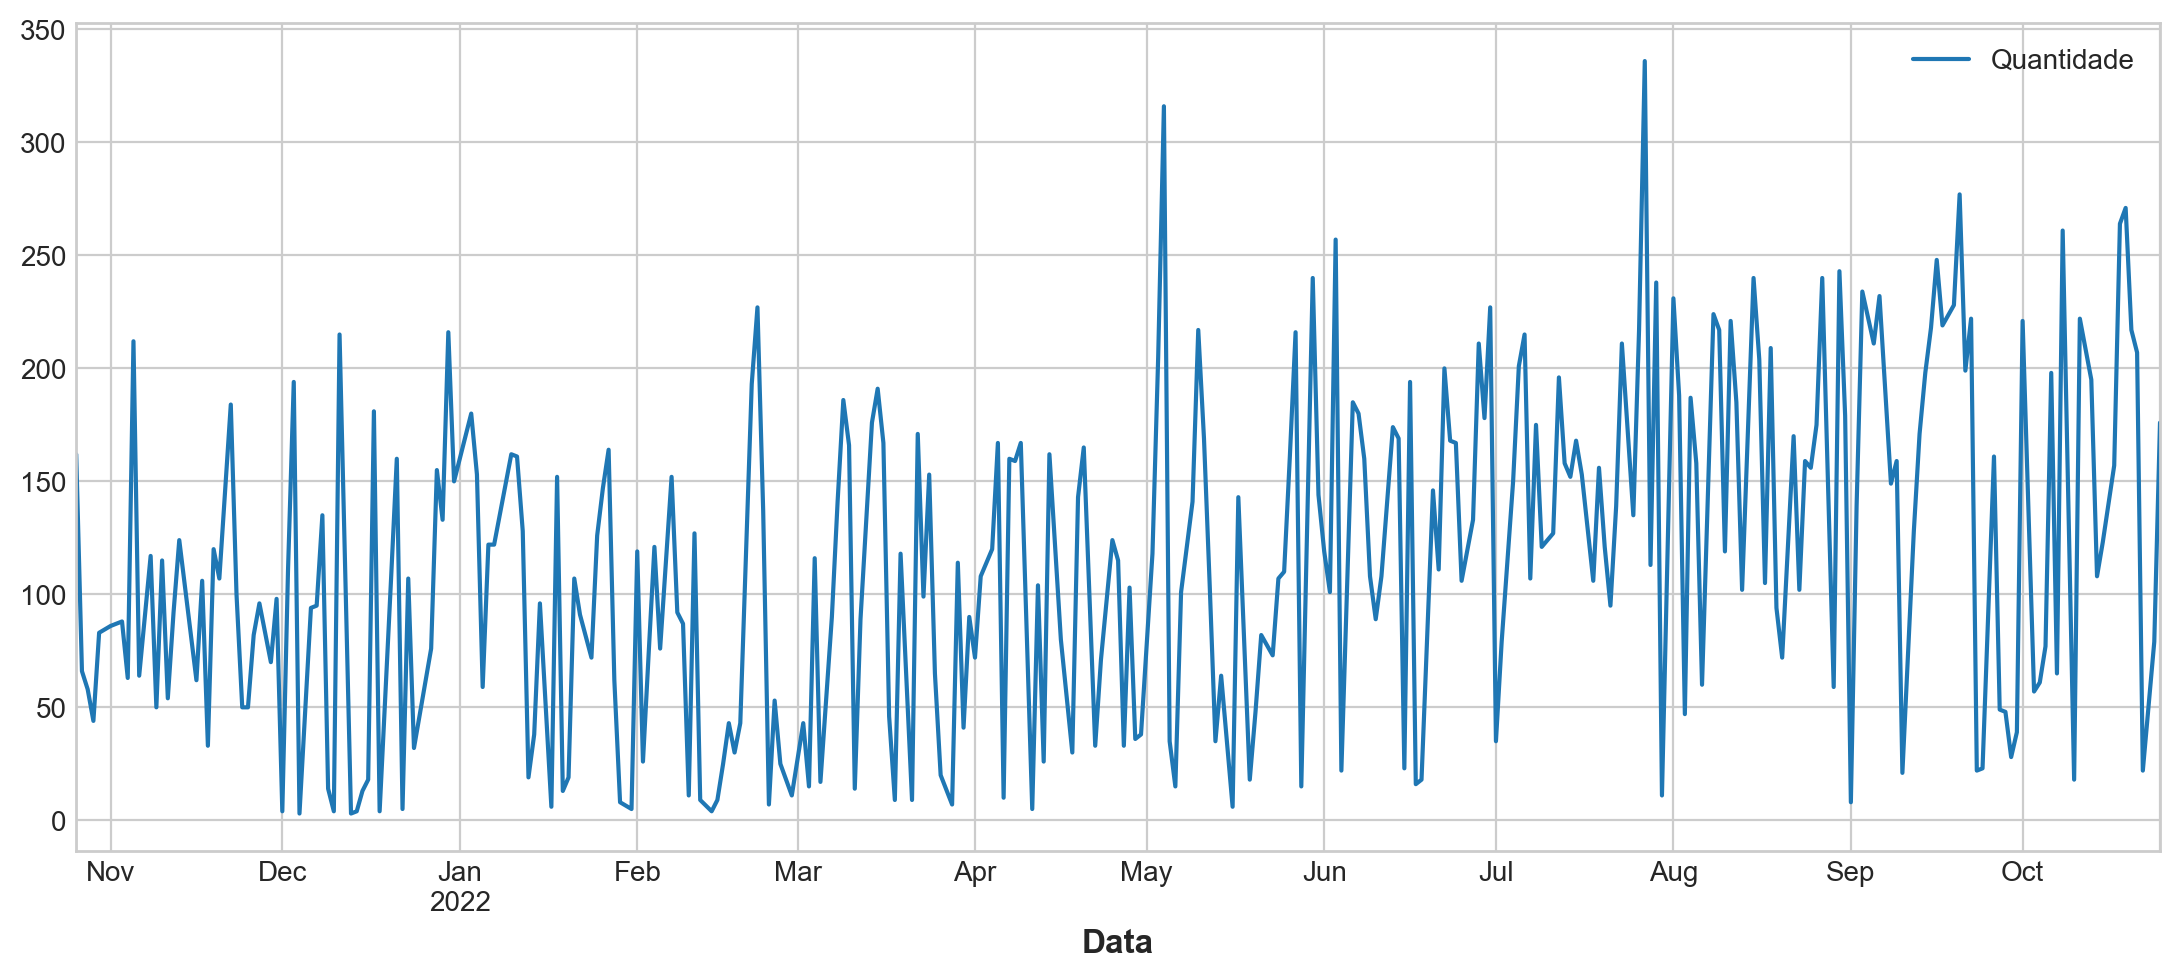

In [6]:
# Plot dos Dados

dataframe.plot()

In [7]:
dp = DeterministicProcess(index=dataframe.index, constant=True, order=1, drop=True,)
X = dp.in_sample()
X.head()

,const,trend
Data,,
2021-10-26,1.0,1.0
2021-10-27,1.0,2.0
2021-10-28,1.0,3.0
2021-10-29,1.0,4.0
2021-10-30,1.0,5.0


In [8]:
y = dataframe["Quantidade"]  
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

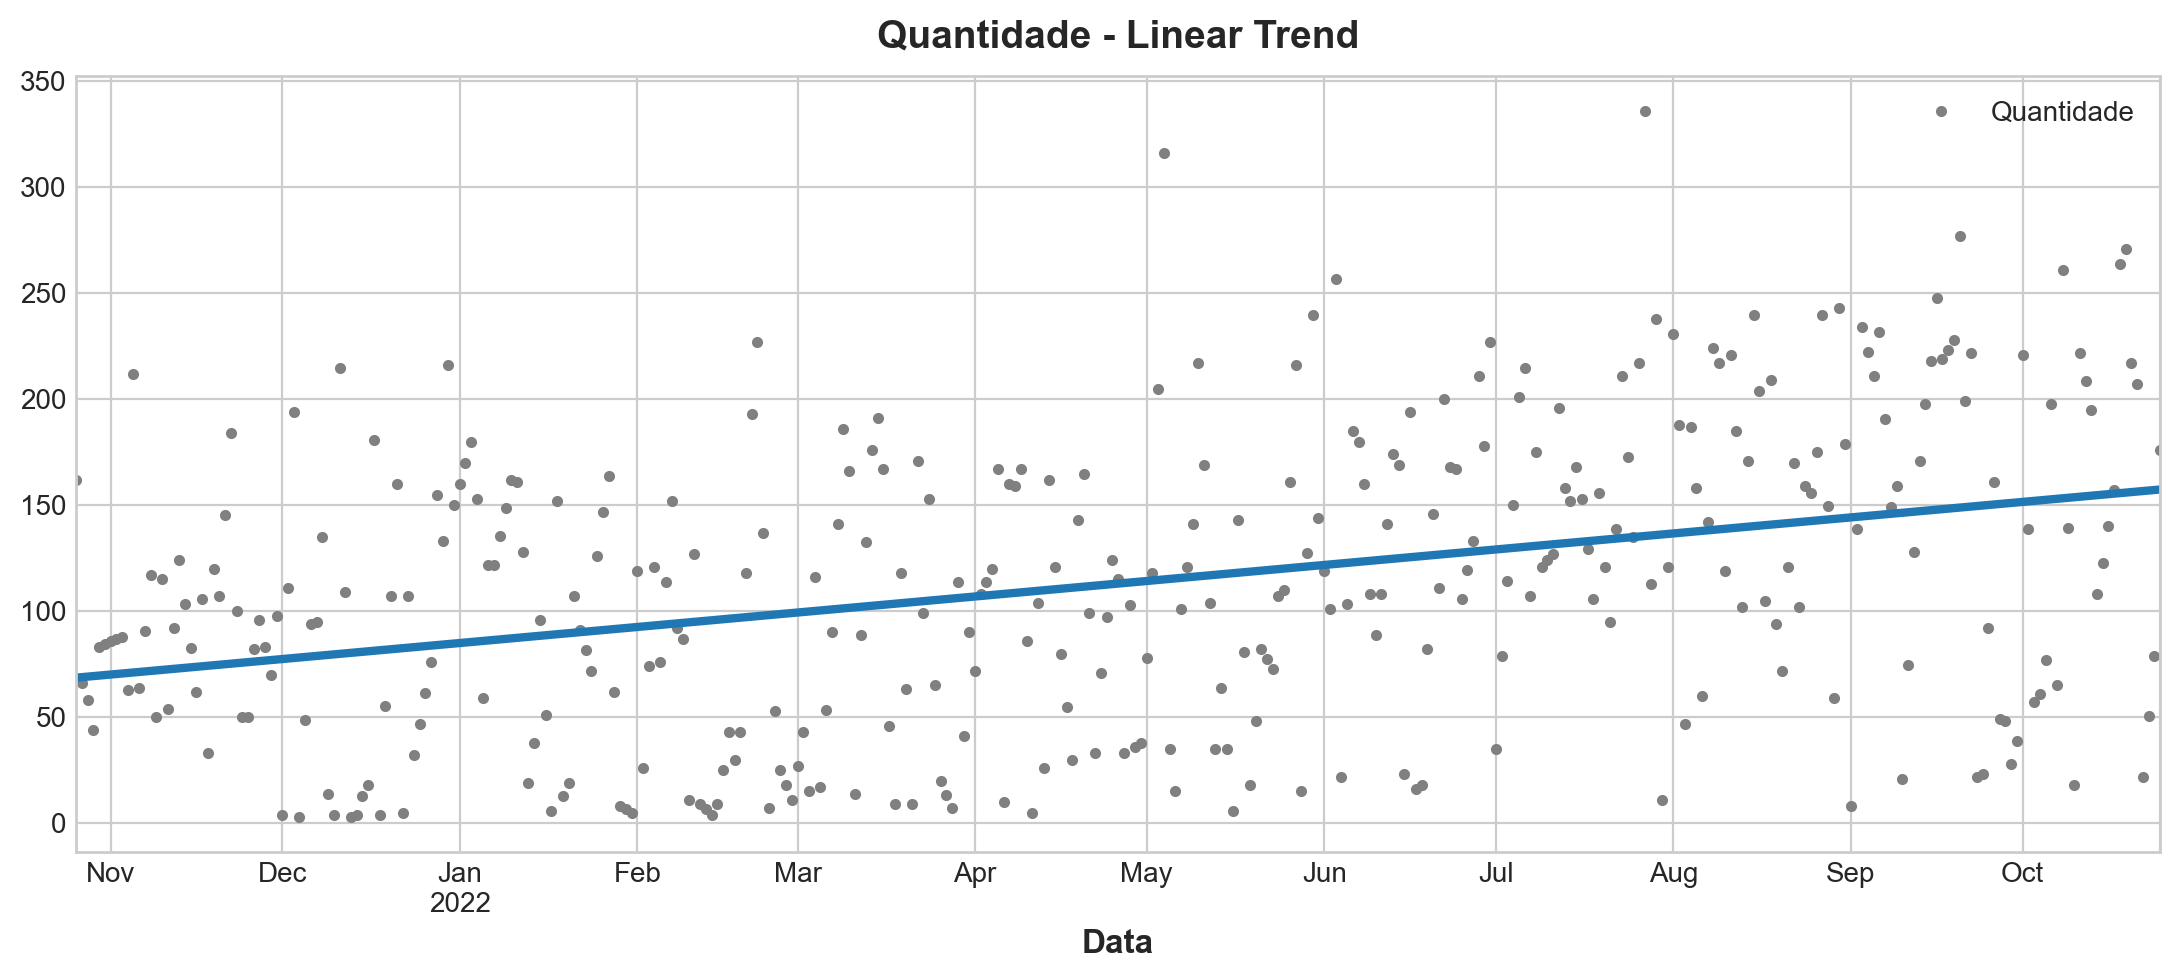

In [9]:
# Tendência linear dos Dados

ax = dataframe.plot(style=".", color="0.5", title="Quantidade - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [10]:
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)

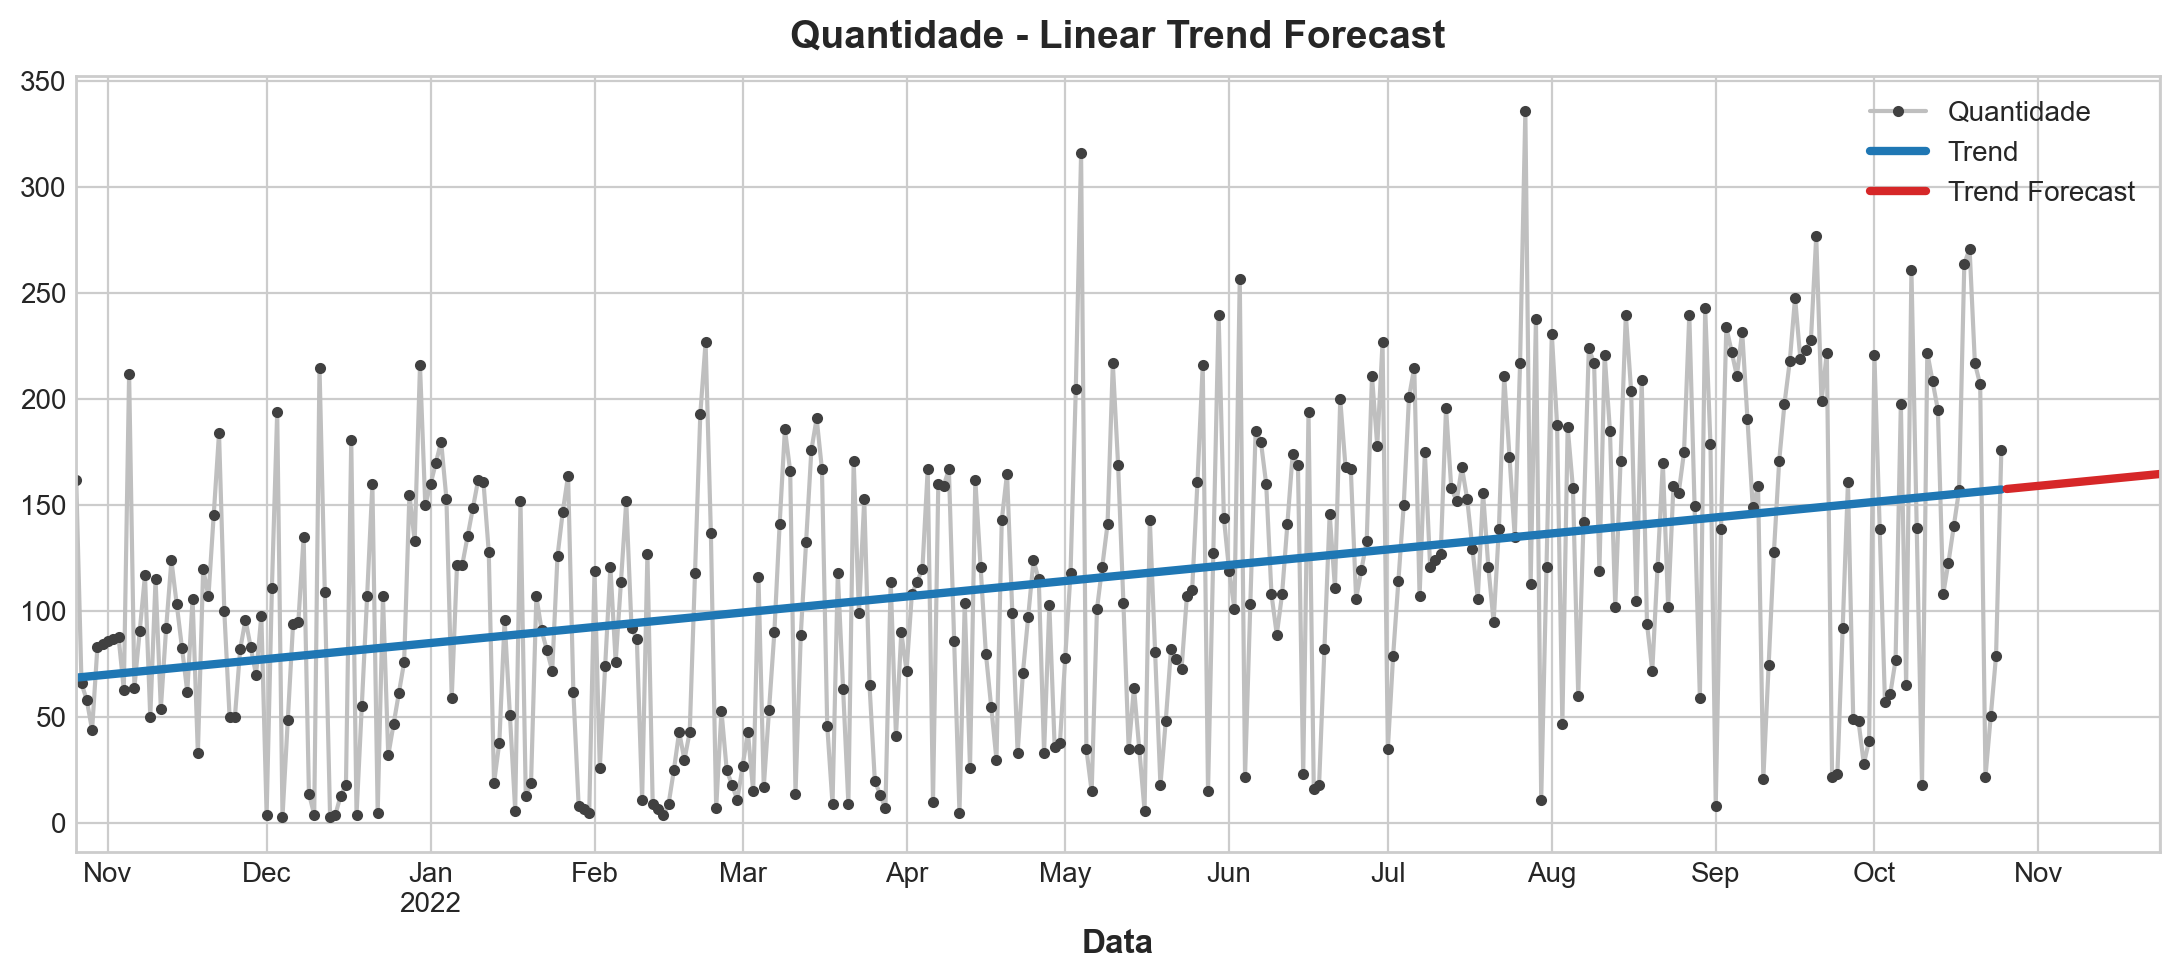

In [11]:
# Forecast de 30 dias

ax = dataframe.plot(title="Quantidade - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [12]:
# estoura o limite de 160
y_fore.loc[y_fore.values >= 160].index[0]

Timestamp('2022-11-05 00:00:00', freq='D')

In [13]:
# Forecast
y_fore

2022-10-26    157.701754
2022-10-27    157.945629
2022-10-28    158.189504
2022-10-29    158.433379
2022-10-30    158.677254
2022-10-31    158.921129
2022-11-01    159.165005
2022-11-02    159.408880
2022-11-03    159.652755
2022-11-04    159.896630
2022-11-05    160.140505
2022-11-06    160.384380
2022-11-07    160.628255
2022-11-08    160.872131
2022-11-09    161.116006
2022-11-10    161.359881
2022-11-11    161.603756
2022-11-12    161.847631
2022-11-13    162.091506
2022-11-14    162.335381
2022-11-15    162.579257
2022-11-16    162.823132
2022-11-17    163.067007
2022-11-18    163.310882
2022-11-19    163.554757
2022-11-20    163.798632
2022-11-21    164.042507
2022-11-22    164.286383
2022-11-23    164.530258
2022-11-24    164.774133
Freq: D, dtype: float64